In [1]:
import cymetric as cym
from cymetric import filters 
from cymetric import graphs 
from cymetric import timeseries 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
file = '../input_files/once_through_sfr.sqlite'
file = cym.tools.dbopen(file)
ev = cym.Evaluator(file, write=False)

In [2]:
## Flow chart
flowchart = graphs.flow_graph(ev)
for node in ['\tUSA\n', '\tSFR_COMPANY\n', '\t"United States Nuclear"\n']:
    flowchart.body.remove(node)
flowchart.render(filename='once_through_sfr_flow', format='svg')


'once_through_sfr_flow.svg'

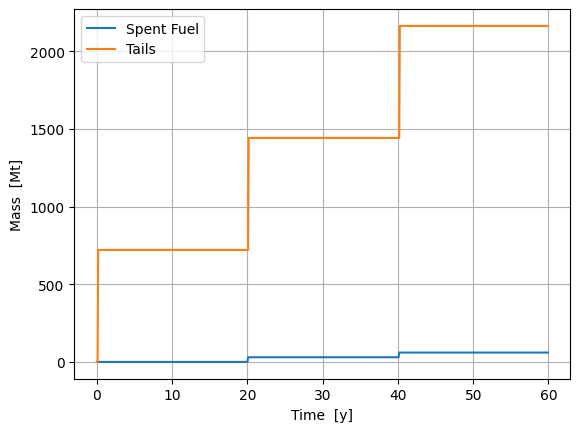

In [3]:
## Waste
hlw = timeseries.transactions(evaler=ev, commodities=['spent_sfr'])
time = hlw['Time']
hlw_cum = hlw['Mass'].cumsum()
llw = timeseries.transactions(evaler=ev, commodities=['tails'])
time = llw['Time']
llw_cum = llw['Mass'].cumsum()
plt.plot(time/12, hlw_cum/1e3, label = 'Spent Fuel')
plt.plot(time/12, llw_cum/1e3, label='Tails')
plt.legend()
plt.grid()
plt.xlabel('Time  [y]')
plt.ylabel('Mass  [Mt]')
plt.savefig('once_through_sfr_waste.png', dpi=600)
plt.show()

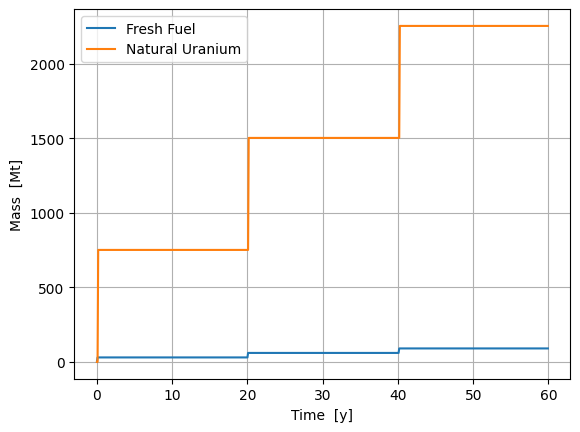

In [6]:
## Fresh
fuel = timeseries.transactions(evaler=ev, commodities=['fresh_sfr'])
time = fuel['Time']
fuel_cum = fuel['Mass'].cumsum()
nat = timeseries.transactions(evaler=ev, commodities=['u_ore'])
time = nat['Time']
nat_cum = nat['Mass'].cumsum() - nat['Mass'][0]
plt.plot(time/12, fuel_cum/1e3, label = 'Fresh Fuel')
plt.plot(time/12, nat_cum/1e3, label='Natural Uranium')
plt.legend()
plt.grid()
plt.xlabel('Time  [y]')
plt.ylabel('Mass  [Mt]')
plt.savefig('once_through_sfr_inputs.png', dpi=600)
plt.show()


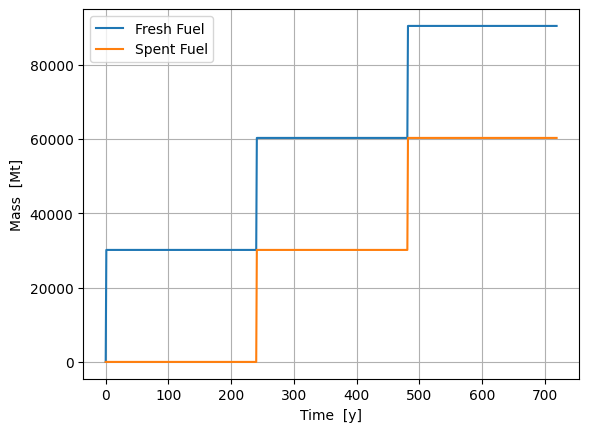

In [4]:
## Fuel
fresh = timeseries.transactions(evaler=ev, commodities=['fresh_sfr'])
time = fresh['Time']
fresh_cum = fresh['Mass'].cumsum()
spent = timeseries.transactions(evaler=ev, commodities=['spent_sfr'])
time = spent['Time']
spent_cum = spent['Mass'].cumsum()
plt.plot(time, fresh_cum, label = 'Fresh Fuel')
plt.plot(time, spent_cum, label='Spent Fuel')
plt.legend()
plt.grid()
plt.xlabel('Time  [y]')
plt.ylabel('Mass  [Mt]')
plt.savefig('once_through_sfr_fuels.png', dpi=600)
plt.show()


In [21]:
ev.eval('Transactions')

,SimId,TransactionId,SenderId,ReceiverId,ResourceId,Commodity,Time
0,597a12e1-b45c-43dd-82e4-4bd01b6cec96,0,23,24,6,u_ore,0
1,597a12e1-b45c-43dd-82e4-4bd01b6cec96,1,24,21,16,fresh_sfr,1
2,597a12e1-b45c-43dd-82e4-4bd01b6cec96,2,23,24,21,u_ore,2
3,597a12e1-b45c-43dd-82e4-4bd01b6cec96,3,24,25,15,tails,2
4,597a12e1-b45c-43dd-82e4-4bd01b6cec96,4,24,21,509,fresh_sfr,241
5,597a12e1-b45c-43dd-82e4-4bd01b6cec96,5,21,25,498,spent_sfr,241
6,597a12e1-b45c-43dd-82e4-4bd01b6cec96,6,23,24,514,u_ore,242
7,597a12e1-b45c-43dd-82e4-4bd01b6cec96,7,24,25,508,tails,242
8,597a12e1-b45c-43dd-82e4-4bd01b6cec96,8,24,21,1004,fresh_sfr,482
9,597a12e1-b45c-43dd-82e4-4bd01b6cec96,9,21,25,993,spent_sfr,482


# Environmental Impact Criterion
need:
* MT nat u
* SWU
* MTDU
* MTIHM
* GWe-Year
* MT LLW
* MT SNF

In [ ]:
MT_NATU = nat['Mass'].sum() / 1e3 - nat['Mass'][0]/1e3
MTDU = llw['Mass'].sum()/1e3
MTIHM = 27146.49966568707 * 3 # from openmc model
GWe_YEAR = 0.1 * 24 * 365 # .1 GWe
MTLLW = MTDU
MTSNF = spent['Mass'].sum()/1e3 


def potential(x):
    return (2*x - 1) * np.log( x / (1 - x))

def SF(xp, xw, xf):
    w_p = (xp - xf) / (xf - xw)
    f_p = (xp - xw) / (xf - xw)
    return potential(xp) + w_p * potential(xw) - f_p * potential(xf)

def SWU(P, tau, xp, xw, xf):
    return P * tau * SF(xp, xw, xf)

enrichs = [0.10777158258420397, 0.12262579994910823, 0.15334238781228013]
masses = [9140.235577672414, 10054.259135439657, 10968.282693206898]
SWUs = []
tails = 0.002
feed = 0.00711
for xp, P in zip(enrichs, masses):
    SWUs.append(SWU(P, 1, xp, tails, feed))
SWU_TOTAL = sum(SWUs)

2253.4683429320985

# Land Use

In [38]:
unit = 'km2 Land'

mining_milling = 2.8e-4 * MT_NATU
conversion = 3.3e-6 * MT_NATU
enrichment = 9e-9 * SWU_TOTAL
deconversion = 9.3e-5 * MTDU

uox = 1.02e-4 * MTIHM

operation = 7.27e-2 * GWe_YEAR
reprocessing = 4.41e-5 * MTIHM

shallow_disposal = 9.74e-6 * MTLLW
geo_repo = 1.5e-3 * MTSNF
interim = 3e-5 * MTSNF

value = mining_milling + conversion + enrichment + deconversion + uox + operation + reprocessing + shallow_disposal + geo_repo + interim
print(f'{value} {unit}')

76.54404316444403 km2 Land


In [37]:
unit = 'ML Water'

mining_milling = 8.5e-1 * MT_NATU
conversion = 6.5e-2 * MT_NATU
enrichment = 2.9e-5 * SWU_TOTAL
deconversion = 5.3e-4 * MTDU

uox = 1.41e-1 * MTIHM

operation = 2.37e4 * GWe_YEAR
reprocessing = 4.83e-1 * MTIHM

shallow_disposal = 2.3e-4 * MTLLW
geo_repo = 1.43e-1 * MTSNF
interim = 0 * MTSNF

value = mining_milling + conversion + enrichment + deconversion + uox + operation + reprocessing + shallow_disposal + geo_repo + interim
print(f'{value} {unit}, or {value/1e6} Tera liters water')

20814115.013800327 ML Water, or 20.814115013800325 Tera liters water


In [36]:
unit = 'kg CO2'

mining_milling = 8.3e4 * MT_NATU
conversion = 2.2e4 * MT_NATU
enrichment = 2.8e1 * SWU_TOTAL
deconversion = -3.2e3 * MTDU

uox = 2.85e5 * MTIHM

operation = 1.16e7 * GWe_YEAR
reprocessing = 5.15e5 * MTIHM

shallow_disposal = 1.82 * MTLLW
geo_repo = (2.49e4 + 6.32e4 + 2.71e4 + 2.91e4 + 1.3e3) * MTSNF
interim = 3.11e4 * MTSNF

value = mining_milling + conversion + enrichment + deconversion + uox + operation + reprocessing + shallow_disposal + geo_repo + interim
print(f'{value} {unit}, or {value / 1e9} Mega tons CO2')

75577279649.76501 kg CO2, or 75.57727964976502 Mega tons CO2
